Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum
from libs.duto_casadi import *
from libs.compressor_class import *
from libs.compression import *
from libs.simulation_duto import *
from libs.model import *
import torch

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real

# Número de nós (comprimento de self.l)

comp = CompressorClass()
compressor = compression(gas, comp, visc)
meu_duto = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)

0.99365 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531123, 0.006138982539123434, 0.0015095858702762542, 0.0003019171740552508, 0.0003019171740552508, 0.0005535148191012933, 0.0004025562320736678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003019171740552508, 0.0, 0.0008051124641473356, 0.0]


In [3]:
from scipy.optimize import fsolve
import numpy as np

# --- Entradas conhecidas ---
u0 = 700
m_dot = 36
# --- Função residual (só para as variáveis livres) ---
def algebraic_residual(z_free, u, compressor):
    """
    Calcula o residual das equações algébricas do compressor
    com T2 e V2 fixos.
    """
    z_full = [z_free[0], z_free[1],
              z_free[2], z_free[3],
              z_free[4], z_free[5],
              z_free[6], z_free[7],
              z_free[8]]
    
    params = [u, m_dot/4, 4000, 300]  
    res = compressor.character_dae(z_full, params)
    return np.array(res).flatten()

Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(
    compressor, m=m_dot/4, N=u0, Gi_1=gas
)

z_guess = [Gimp.T, Gimp.V, Gdif.T, Gdif.V, G2s.T, G2s.V, G2.T, G2.V, gas.V]


# --- Resolve as equações algébricas ---
z_free_sol = fsolve(algebraic_residual, z_guess, args=(u0, compressor))

# Reconstrói o vetor completo com T2, V2 fixos
z_sol = [z_free_sol[0], z_free_sol[1],
         z_free_sol[2], z_free_sol[3],
         z_free_sol[4], z_free_sol[5],
         z_free_sol[6], z_free_sol[7],
         z_free_sol[8]]

print("Solução das variáveis algébricas:")
print(z_sol)

Solução das variáveis algébricas:
[np.float64(320.96133173352456), np.float64(0.48333044297385386), np.float64(320.35851600459756), np.float64(0.49511683401837436), np.float64(338.8953958002702), np.float64(0.35506519067469255), np.float64(344.38357043732435), np.float64(0.36277097658886776), np.float64(0.583790379032516)]


In [4]:
gas_p = gas.copy_change_conditions(z_sol[6], None, z_sol[7], 'gas')

n_nodes = len(meu_duto.l)
A = np.pi * (D**2) / 4  
MM = gas_p.mixture.MM_m  
v_kg = z_sol[7] / MM
rho = 1 / v_kg
w_teste = m_dot / (A * rho)
y0 = np.array([z_sol[6], z_sol[7], w_teste])

x_avaliar = meu_duto.l

# --- Criação do integrador CVODES ---
x = SX.sym('x')
y = SX.sym('y', 3)  # [T, V, w]
dy = meu_duto.estacionario(x, y)
f = Function('f', [x, y], [dy])

dae = {'x': y, 'p': x, 'ode': f(x, y)}

# --- Integração incremental ao longo do duto ---
y_current = y0.reshape(-1, 1)
Y_sol = [y_current.flatten()]

for i in range(1, len(x_avaliar)):
    dx = x_avaliar[i] - x_avaliar[i - 1]
    F_seg = integrator('F_seg', 'cvodes', dae,
                       {'tf': dx})
    res = F_seg(x0=y_current, p=x_avaliar[i - 1])
    y_current = res['xf']
    Y_sol.append(y_current.full().flatten())

Y_sol = np.array(Y_sol)
T_sol_estc = Y_sol[:, 0]
V_sol_estc = Y_sol[:, 1]
w_sol_estc = Y_sol[:, 2]

# --- Cálculo da pressão ---
P_sol_estc = []
for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)

# print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10} | {'P [Pa]':>10}")
# print("-"*60)
# for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
#     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.2f}")

CasADi - 2025-11-28 00:28:14 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


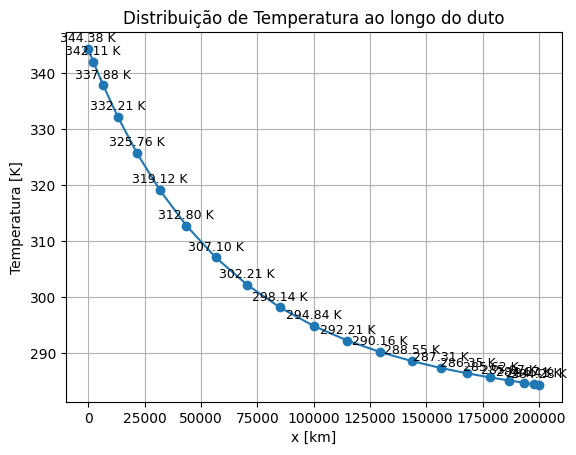

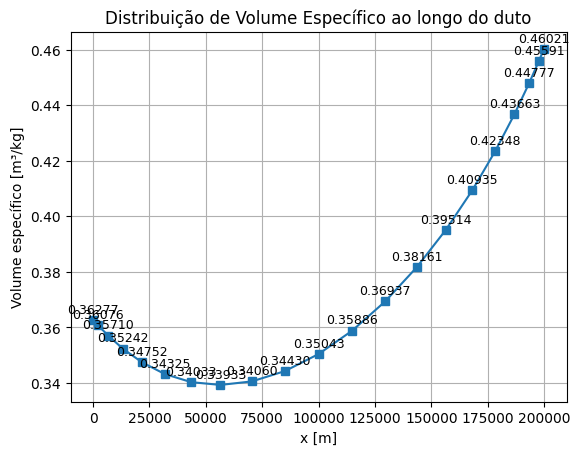

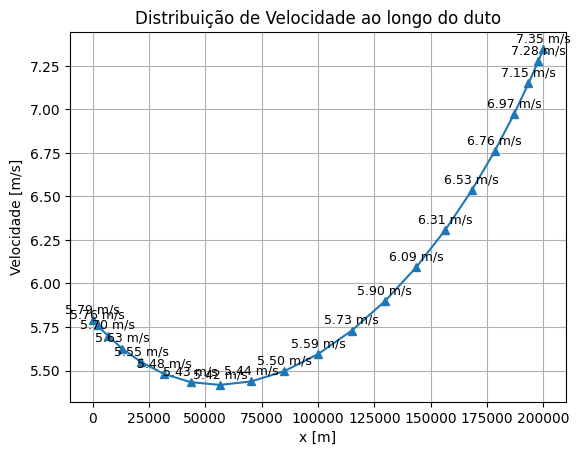

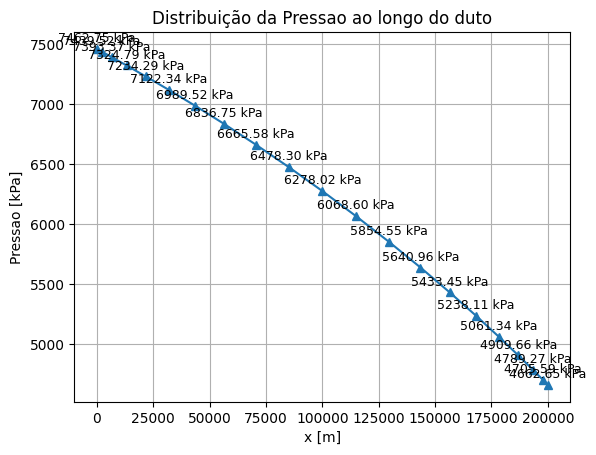

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [6]:
import random

def gerar_rotacoes(n=250, minimo=500, maximo=1000, passo_max=50):
    seq = []
    
    # começa em um valor aleatório dentro dos limites
    atual = random.randint(minimo, maximo)
    seq.append(atual)

    for _ in range(n - 1):
        # variação entre -50 e +50
        delta = random.randint(-passo_max, passo_max)
        proximo = atual + delta

        # limitar aos bounds
        proximo = max(minimo, min(maximo, proximo))

        seq.append(proximo)
        atual = proximo

    return seq


sequencia_rot = gerar_rotacoes()
print(sequencia_rot)

[859, 899, 877, 835, 785, 768, 806, 787, 747, 795, 837, 821, 779, 809, 775, 785, 827, 863, 867, 895, 917, 909, 873, 845, 851, 809, 806, 778, 759, 754, 767, 735, 699, 654, 654, 633, 634, 683, 669, 672, 692, 669, 695, 739, 736, 724, 699, 741, 714, 689, 695, 684, 640, 662, 682, 717, 760, 800, 831, 803, 811, 808, 783, 778, 754, 770, 789, 809, 821, 865, 910, 907, 882, 916, 895, 892, 917, 895, 893, 875, 867, 856, 877, 845, 881, 902, 913, 866, 906, 885, 849, 865, 867, 877, 886, 837, 802, 845, 835, 796, 786, 794, 799, 769, 725, 759, 791, 759, 753, 717, 742, 694, 678, 686, 636, 668, 676, 690, 699, 735, 688, 699, 736, 688, 690, 644, 603, 606, 604, 633, 606, 620, 575, 623, 622, 586, 572, 545, 502, 500, 531, 500, 500, 513, 500, 500, 534, 582, 566, 547, 524, 501, 539, 508, 500, 500, 500, 504, 550, 565, 531, 500, 545, 540, 579, 536, 540, 564, 526, 501, 509, 537, 519, 522, 508, 533, 500, 511, 530, 550, 527, 521, 500, 516, 533, 528, 562, 520, 514, 527, 526, 516, 515, 556, 588, 553, 527, 558, 547, 573,

In [7]:
# meu_sistema = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)
# # --- Condições iniciais ---
# T0 = T_sol_estc
# V0 = V_sol_estc
# w0 = w_sol_estc
# gas_temp = gas.copy_change_conditions(T_sol_estc[-1], None, V_sol_estc[-1], 'gas')
# y0 = np.empty(n_nodes * 3)
# y0[0::3] = T0
# y0[1::3] = V0
# y0[2::3] = w0
# z0 = z_sol + [rho * A * w_sol_estc[0], gas_temp.P]
# y0 = np.array(y0, dtype=float)
# z0 = np.array(z0, dtype=float)
# print(z0)
# u0 = np.array([700.0, 4000, 300.0, 2.1506])
# dt = 300
# # --- Simulação temporal ---
# n_steps = 1500 # número de passos
# t_sim = np.linspace(0, n_steps * dt, n_steps)
# y_sol = np.zeros((n_steps, len(y0)))

# sim = SimuladorDuto(meu_sistema)
# resultados = sim.run(y0, z0, u0, 250, 200, sequencia_rot, dt)
# sim.plotar()

In [8]:
# RNN_train, x_train, y_train, x_min, x_max, y_min, y_max = sim.train_dataset(3)


# N = x_train.shape[0]
# cut = int(0.7 * N)

# # Split sequencial (mantém a ordem temporal)
# x_train_split = x_train[:cut]
# y_train_split = y_train[:cut]

# x_val_split = x_train[cut:]
# y_val_split = y_train[cut:]

# print("Treino:", x_train_split.shape, y_train_split.shape)
# print("Validação:", x_val_split.shape, y_val_split.shape)

In [9]:
# torch.save({
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_val": x_val_split,
#     "y_val": y_val_split,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max
# }, "dataset.pt")

In [10]:
data = torch.load("dataset.pt")

x_train = data["x_train"]
y_train = data["y_train"]
x_val_split = data["x_val"]
y_val_split = data["y_val"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


N = x_train.shape[0]
cut = int(0.7 * N)

# Split sequencial (mantém a ordem temporal)
x_train_split = x_train[:cut]
y_train_split = y_train[:cut]

x_val_split = x_train[cut:]
y_val_split = y_train[cut:]

print("Treino:", x_train_split.shape, y_train_split.shape)
print("Validação:", x_val_split.shape, y_val_split.shape)

Treino: torch.Size([34997, 3, 4]) torch.Size([34997, 3])
Validação: torch.Size([15000, 3, 4]) torch.Size([15000, 3])


In [11]:
def objective(trial):

    # ----- HYPERPARAMETROS A AJUSTAR PELO OPTUNA -----
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 256)
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # ----- CRIA O MODELO -----
    model = RNNModelWrapper(
        input_dim=x_train.shape[-1],
        hidden_dim=hidden_dim,
        output_dim=y_train.shape[-1],
        num_layers=num_layers,
        x_min=x_min, x_max=x_max,
        y_min=y_min, y_max=y_max,
        lr=lr,
        device="cpu"
    )

    # ----- TREINO CURTO PARA AVALIAR -----
    model.train_model(x_train_split, y_train_split, epochs=500)  # rápido p/ Optuna

    # ----- AVALIAÇÃO  -----
    model.eval()
    with torch.no_grad():
        preds = model(x_val_split.float())  # garante float
        loss = torch.mean((preds - y_val_split.float())**2)  # tensor

    return float(loss)  # Retorna um float para o Optuna

In [12]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# print("Melhores hiperparâmetros:")
# print(study.best_trial.params)
# print("Loss mínima:", study.best_value)

In [34]:

from libs.model import *

model = RNNModelWrapper(
    input_dim=x_train.shape[-1],
    hidden_dim=230,
    output_dim=y_train.shape[-1],
    num_layers= 2,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    lr=0.00028912058475362396,
    device="cpu"
)

model.train_model(x_train_split, y_train_split, epochs=3000)

/home/matheus/Trabalho/UFBA/Duto_Rede_de_gas/PSE_NE_2025/libs/model.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_min = torch.tensor(x_min, dtype=torch.float32).to(device)
/home/matheus/Trabalho/UFBA/Duto_Rede_de_gas/PSE_NE_2025/libs/model.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_max = torch.tensor(x_max, dtype=torch.float32).to(device)
/home/matheus/Trabalho/UFBA/Duto_Rede_de_gas/PSE_NE_2025/libs/model.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_min = torch.tensor(y_min, dtype=torch.float3

Epoch 10/3000 | Loss = 0.12329 | Per-variable = [[3.4917071e-02 7.6935440e-02 4.9503371e-05]
 [3.1185647e-02 4.0766977e-02 1.5873099e-03]
 [2.7999543e-02 1.8557167e-02 5.4400554e-03]
 ...
 [3.8649145e-01 1.5013120e-01 3.9378902e-01]
 [3.8649961e-01 1.5007743e-01 3.9378986e-01]
 [3.8650724e-01 1.5002555e-01 3.9379051e-01]]
Epoch 20/3000 | Loss = 0.02720 | Per-variable = [[0.02075768 0.02082032 0.13759184]
 [0.02719454 0.04043687 0.08006562]
 [0.03099429 0.06461537 0.04921478]
 ...
 [0.03775446 0.04864322 0.06894197]
 [0.03776049 0.04867209 0.06893556]
 [0.03776628 0.04870003 0.06892927]]
Epoch 30/3000 | Loss = 0.01595 | Per-variable = [[0.00040178 0.03771468 0.12748429]
 [0.00244578 0.01608077 0.08160044]
 [0.0044025  0.00445333 0.05533024]
 ...
 [0.00183011 0.09987072 0.00158549]
 [0.00182855 0.0998276  0.00158485]
 [0.00182702 0.09978562 0.00158424]]
Epoch 40/3000 | Loss = 0.00808 | Per-variable = [[0.00460194 0.00147109 0.0569151 ]
 [0.00177882 0.00828338 0.02557014]
 [0.00076672 0.0

/tmp/ipykernel_50573/3480673093.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.array(y_true)


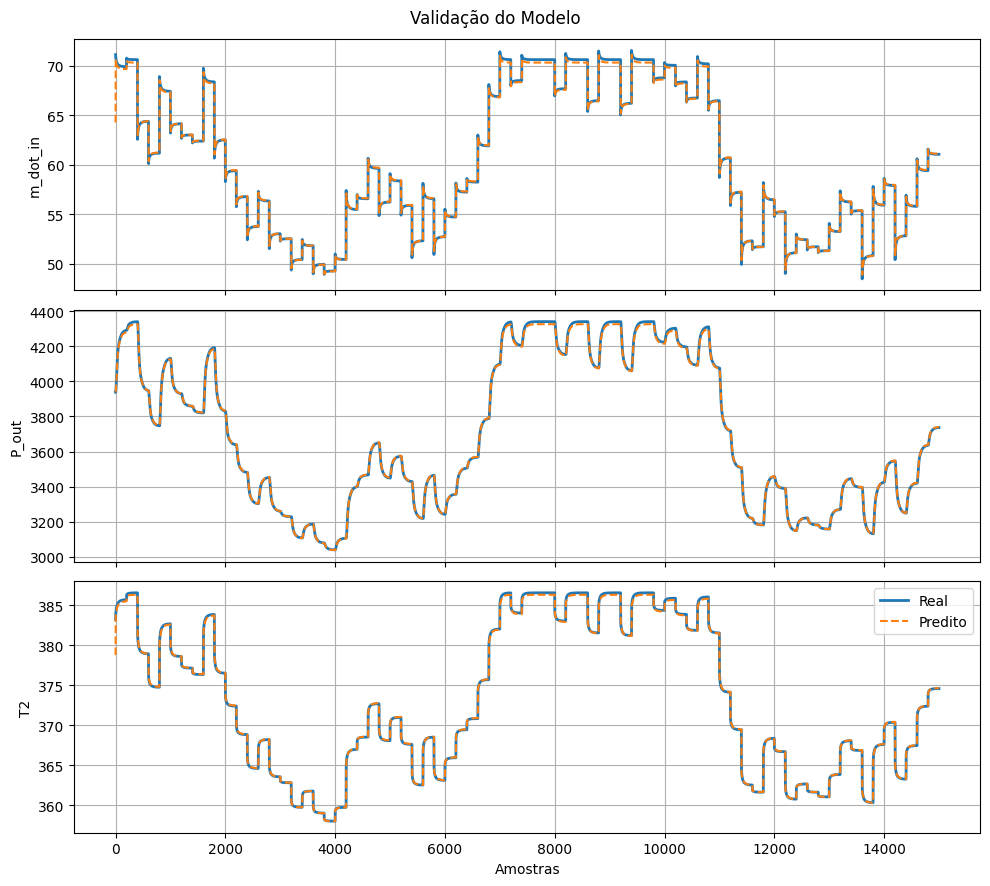

In [35]:
def plot_outputs(y_true, y_pred, labels=None, title="Validação do Modelo"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_vars = y_true.shape[1]

    if labels is None:
        labels = [f"Var {i+1}" for i in range(n_vars)]

    fig, axs = plt.subplots(n_vars, 1, figsize=(10, 3*n_vars), sharex=True)

    if n_vars == 1:
        axs = [axs]

    for i in range(n_vars):
        axs[i].plot(y_true[:, i], label="Real", linewidth=2)
        axs[i].plot(y_pred[:, i], label="Predito", linestyle="--")
        axs[i].set_ylabel(labels[i])
        axs[i].grid(True)

    axs[-1].set_xlabel("Amostras")
    fig.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


y_pred = model.predict(x_val_split)
y_pred = np.squeeze(y_pred) 
plot_outputs(y_val_split, y_pred, labels=["m_dot_in", "P_out", "T2"])

In [36]:
def test_model(model, x_test, interval):
    model.eval()
    m_dot_in = [
        x_test[0, 0, 0].item(),
        x_test[0, 1, 0].item(),
        x_test[0, 2, 0].item(),
    ]
    
    P_out = [
        x_test[0, 0, 1].item(),
        x_test[0, 1, 1].item(),
        x_test[0, 2, 1].item(),
    ]
    
    T_in = [
        x_test[0, 0, 2].item(),
        x_test[0, 1, 2].item(),
        x_test[0, 2, 2].item(),
    ]
    
    input_tensor = torch.zeros((1, 3, 4), dtype=torch.float32)

    for i in range(len(interval)):
        input_tensor[0, :, 0] = torch.tensor(m_dot_in[-3:])
        input_tensor[0, :, 1] = torch.tensor(P_out[-3:])
        input_tensor[0, :, 2] = torch.tensor(T_in[-3:])
        input_tensor[0, :, 3] = x_test[i, :, 3]
        with torch.no_grad():
            prediction100 = model.predict(input_tensor)
        m_dot_in.append(prediction100[0, 0].item())
        P_out.append(prediction100[0, 1].item())
        T_in.append(prediction100[0, 2].item())
    return m_dot_in, P_out, T_in

In [37]:
print(x_val_split)
interval = range(2000)   # por exemplo, simular 300 passos
(m_dot_in, P_out, T_in) = test_model(model, x_val_split, interval)

tensor([[[  64.2524, 3938.3682,  378.7447,  953.0000],
         [  64.2525, 3938.3230,  378.7445,  953.0000],
         [  64.2526, 3938.2791,  378.7444,  953.0000]],

        [[  64.2525, 3938.3230,  378.7445,  953.0000],
         [  64.2526, 3938.2791,  378.7444,  953.0000],
         [  71.0988, 3938.2361,  383.2219,  995.0000]],

        [[  64.2526, 3938.2791,  378.7444,  953.0000],
         [  71.0988, 3938.2361,  383.2219,  995.0000],
         [  70.9801, 3938.1987,  383.4697,  995.0000]],

        ...,

        [[  61.0504, 3736.7856,  374.5717,  927.0000],
         [  61.0504, 3736.8091,  374.5717,  927.0000],
         [  61.0503, 3736.8318,  374.5718,  927.0000]],

        [[  61.0504, 3736.8091,  374.5717,  927.0000],
         [  61.0503, 3736.8318,  374.5718,  927.0000],
         [  61.0503, 3736.8540,  374.5719,  927.0000]],

        [[  61.0503, 3736.8318,  374.5718,  927.0000],
         [  61.0503, 3736.8540,  374.5719,  927.0000],
         [  61.0502, 3736.8755,  374.5720

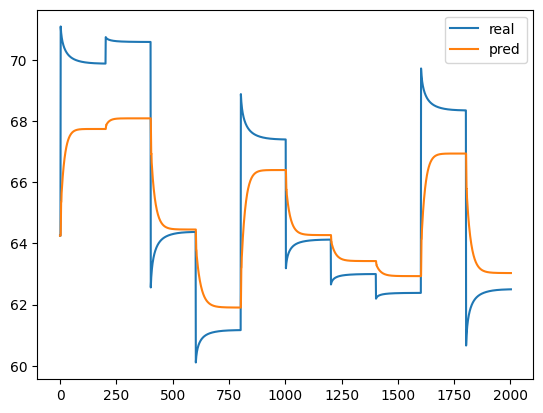

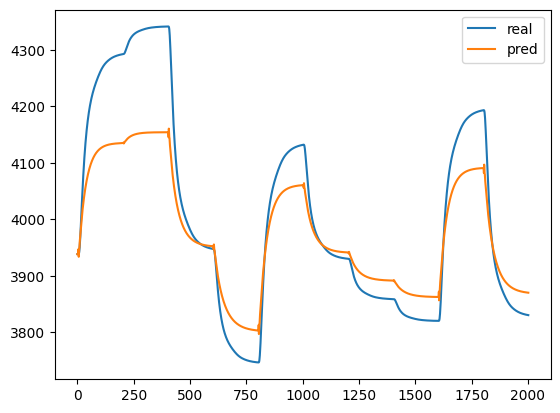

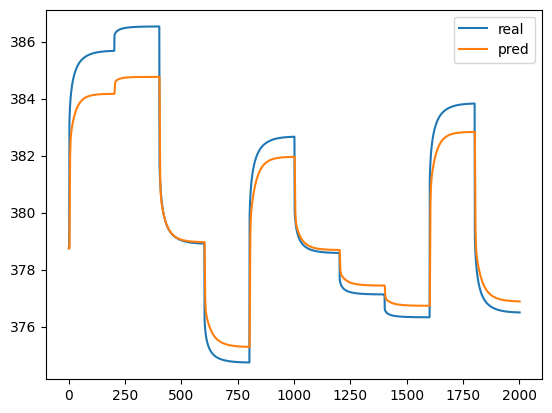

In [38]:
import matplotlib.pyplot as plt

# Converte para numpy
import numpy as np
pred_m = np.array(m_dot_in)
pred_P = np.array(P_out)
pred_T = np.array(T_in)

# valores reais (mesmo comprimento)
real_m = x_val_split[:len(pred_m), 0, 0].cpu().numpy()
real_P = x_val_split[:len(pred_P), 0, 1].cpu().numpy()
real_T = x_val_split[:len(pred_T), 0, 2].cpu().numpy()

# ---- m_dot_in ----
plt.plot(real_m, label="real")
plt.plot(pred_m, label="pred")
plt.legend()
plt.show()

# ---- P_out ----
plt.plot(real_P, label="real")
plt.plot(pred_P, label="pred")
plt.legend()
plt.show()

# ---- T_in ----
plt.plot(real_T, label="real")
plt.plot(pred_T, label="pred")
plt.legend()
plt.show()
